##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Interactive demo: Learning static analyses with the GFSA layer

This notebook is designed to walk you through training the GFSA layer to perform simple static analyses on Python code, similar to the static analysis experiments in the paper.



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/google-research/blob/master/gfsa/notebooks/demo_learning_static_analyses.ipynb)

## Setting up the environment

These instructions are designed for running this demo using Google Colab; if you are using a different environment, the setup instructions may differ!

If you want to follow along, the first step is to connect the Colab runtime to a TPU. You can use the "Runtime > Change runtime type" option in the toolbar above.

Next, install necessary dependencies:

In [ ]:
# Download the GFSA codebase
!git clone https://github.com/google-research/google-research.git --depth=1

Cloning into 'google-research'...
remote: Enumerating objects: 10043, done.
remote: Counting objects: 100% (10043/10043), done.
remote: Compressing objects: 100% (8038/8038), done.
remote: Total 10043 (delta 1443), reused 7963 (delta 1209), pack-reused 0
Receiving objects: 100% (10043/10043), 109.57 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (1443/1443), done.
Checking out files: 100% (10525/10525), done.


In [ ]:
import os
os.chdir("google-research")

In [ ]:
# Install Python packages
!pip install flax labmaze optax tensor2tensor

     |████████████████████████████████| 153kB 5.1MB/s 
     |████████████████████████████████| 4.9MB 18.0MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 1.5MB 39.6MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 358kB 47.8MB/s 
     |████████████████████████████████| 983kB 32.2MB/s 
     |████████████████████████████████| 348kB 37.9MB/s 
     |████████████████████████████████| 655kB 45.3MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 194kB 41.5MB/s 
     |████████████████████████████████| 368kB 32.8MB/s 
     |████████████████████████████████| 5.3MB 46.7MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 245kB 43.8MB/s 
  Created wheel for bz2file: filename=bz2file-0.98-cp36-none-any.whl size=6884 sha256=45ffa796f114e5edbf92475ab42982efa3b9b026801025bd0f9217ef533918e8
  Stored in direct

Make sure JAX can see the TPU:

In [ ]:
# See https://github.com/google/jax/blob/master/cloud_tpu_colabs/JAX_demo.ipynb
import requests
import os

if 'COLAB_TPU_ADDR' not in os.environ:
  raise RuntimeError("Please connect to a TPU runtime first!")

if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# Use TPU Driver as JAX's backend.
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

grpc://10.48.40.138:8470


In [ ]:
import jax
jax.devices()

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]

You should see 8 TPU devices connected above!

## Imports and configuration

Let's import and set up some things we will need later:

In [ ]:
import functools
import itertools
import sys
import datetime

from absl import logging
from absl import flags

import astunparse
import dataclasses
import flax
import gast
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import jax.numpy as jnp

In [ ]:
np.set_printoptions(linewidth=150)
logging.use_python_logging()
logging.set_verbosity("info")
logging.set_stderrthreshold("info")

In [ ]:
from gfsa import automaton_builder
from gfsa import generic_ast_graphs
from gfsa import graph_types
from gfsa import jax_util
from gfsa import py_ast_graphs
from gfsa import schema_util

from gfsa.datasets import data_loading
from gfsa.datasets import graph_bundle
from gfsa.datasets import graph_edge_util
from gfsa.datasets.random_python import tasks
from gfsa.datasets.random_python import python_numbers_control_flow

from gfsa.model import automaton_layer
from gfsa.model import edge_supervision_models
from gfsa.model import model_util

from gfsa.training import train_edge_supervision_lib
from gfsa.training import train_util
from gfsa.training import simple_runner
from gfsa.training import learning_rate_schedules

from gfsa import visualization
import gfsa.visualization.ndarrays
from gfsa.visualization.pprint import pprint
from gfsa.visualization.pytrees import summarize_tree

## Generating random Python functions

In this notebook, we will be focusing on graph representations of random Python programs, similar to those used in the static analysis experiments in the paper. We can start by generating some random Python programs!

The GFSA codebase includes functions for generating random Python functions of configurable size. Python functions are represented as `gast.AST` objects, which can be converted back to source code using `astunparse.unparse`:

In [ ]:
the_ast = tasks.make_ast(25, np.random.RandomState(6))
print(astunparse.unparse(gast.gast_to_ast(the_ast)))



def random_function(a, b):
    a = b
    if (True and (a > foo_2(b, b))):
        b = b
    else:
        v2 = a



In [ ]:
pprint(the_ast)

Module(
    body=[FunctionDef(
              name='random_function',
              args=arguments(
                       args=[Name(id='a', ctx=Param(), annotation=None, type_comment=None),
                             Name(id='b', ctx=Param(), annotation=None, type_comment=None)],
                       posonlyargs=[],
                       vararg=None,
                       kwonlyargs=[],
                       kw_defaults=[],
                       kwarg=None,
                       defaults=[]),
              body=[Assign(
                        targets=[Name(id='a', ctx=Store(), annotation=None, type_comment=None)],
                        value=Name(id='b', ctx=Load(), annotation=None, type_comment=None)),
                    If(
                        test=BoolOp(
                                 op=And(),
                                 values=[Constant(value=True, kind=None),
                                         Compare(
                                             l

The first argument to `make_ast` is the number of AST nodes to generate, and the second is the (optional) random seed to use. For instance, here's a larger function:

In [ ]:
the_ast_larger = tasks.make_ast(150, np.random.RandomState(1234))
print(astunparse.unparse(gast.gast_to_ast(the_ast_larger)))



def random_function(a, b):
    if True:
        a = a
        if (b < foo_1(bar_4(b, a, foo_4(b, b, b, a), a))):
            b = bar_4(foo_2(10, a), (b - b), b, bar_2(b, a))
            v2 = 14
        b = bar_4(b, ((b / 50) * (a / b)), a, ((a * 46) / bar_1(b)))
        a = b
    v2 = bar_4((b / foo_1(b)), a, (a + a), a)
    b = foo_2(bar_2(bar_2(94, v2), a), foo_2(bar_1(v2), foo_2(v2, a)))
    for v3 in range(int(b)):
        v4 = (b / a)
        while True:
            v2 = foo_2(v2, b)
    a = b
    b = (b * 93)
    v3 = v2
    print(bar_1(10))



## Interpreting Python functions as MDPs



In order to run a GFSA layer on our functions, we need to convert them into graphs, and then impose an MDP structure on those graphs.

This process is performed over two steps:

- First, convert the Python AST into a generic representation of abstract syntax trees.
- Next, use an "AST specification" to transform the generic AST into an MDP. This describes what fields each AST node has, and how many of each there are. This information is used to determine what the states, actions, and transitions in the MDP should be. For instance, since a return node may or may not have a value, the MDP has an action for going to the value of a return node, and an observation that indicates that the value was missing. Similarly, since a function call may have many arguments, the MDP has states that track which argument the agent is visiting, actions that move to previous or next arguments, and an observation for reaching the end of the list.

<br><br>

--- 

💬&nbsp; *Note:* If you want to apply the GFSA layer to a different type of AST, you need to:

- write a function to convert from that AST to the generic AST representation shown below
- define an AST specification for it (either by hand, or by using `ast_spec_inference.py`)

If you want to apply the GFSA layer to a graph that isn't an AST, you need to describe the MDP in more detail. See the notebook ["Using the GFSA layer with new tasks"][new-tasks-colab], which describes how to do this!

[new-tasks-colab]: https://colab.research.google.com/github/google-research/google-research/blob/master/gfsa/notebooks/guide_for_new_tasks.ipynb

---

After the first step, we have the same tree structure as before, but instead of various instances of `gast.AST` classes, we now have `GenericASTNode` objects tagged with numeric IDs and string types (which makes it easier to manipulate in a uniform way):

In [ ]:
generic_ast = py_ast_graphs.py_ast_to_generic(the_ast)
pprint(generic_ast)

GenericASTNode(
    node_id=140157879314192,
    node_type='Module',
    fields={'body': [GenericASTNode(
                         node_id=140157879313632,
                         node_type='FunctionDef',
                         fields={'args': [GenericASTNode(
                                              node_id=140157879316432,
                                              node_type='arguments',
                                              fields={'args': [GenericASTNode(
                                                                   node_id=140157879315816,
                                                                   node_type='Name',
                                                                   fields={'ctx': [GenericASTNode(
                                                                                       node_id=140157879316152,
                                                                                       node_type='Param',
                       

The second step produces a "flat" representation of the tree as a graph-based MDP. Each item in the returned dictionary has an autogenerated key (based on the path through the AST from the root node to each AST node), and a `GraphNode` value that specifies the type of the node and the set of possible MDP transitions.

<br>

---

*Note on terminology:* In the GFSA codebase, we represent MDPs as a special type of directed graph, and use some terms interchangeably. In particular:

- Every node in the graph corresponds to a possible location of the agent in the environment.
- An *out-edge* connects each graph node to the other graph nodes that the agent could move TO when at this location. This determines the action space for the agent; the agent chooses an out-edge type, and then moves to (one of) the destination nodes for that out-edge type.
- An *in-edge* connects each graph node to the other graph nodes that the agent could move FROM when arriving at this location. This determines the observation space for the agent; when arriving at a node, it will observe the in-edge type that was used to enter the node.
- Each edge in the graph is associated with both an out-edge type and an in-edge type, which specifies how the agent chooses to cross this edge and the observation it receives when it does so. These will often be different. As an example, for a graph representing an AST where B is the left child of A,
the edge from A to B might have outgoing type "left child" and incoming type
"parent"; then an agent can choose to move to the left child, and upon doing so observes that it has arrived at that node from its parent.
- An *input-tagged node* is a pair of (node id, in-edge type). This specifies both the location of an agent and the observation that agent receives at that location. When solving for the absorbing distribution, the set of input-tagged nodes determines the size of the transition matrix.

See `graph_types.py` for more information about the notation used.

---

In [ ]:
mdp_graph, id_conversion_map = generic_ast_graphs.ast_to_graph(generic_ast, ast_spec=py_ast_graphs.PY_AST_SPECS)
pprint(mdp_graph)

{'root__Module': GraphNode(
                     node_type='Module',
                     out_edges={'body_out_all': [InputTaggedNode(
                                                     node_id='root_body_0__Module_body-seq-helper',
                                                     in_edge='parent_in')],
                                'body_out_first': [InputTaggedNode(
                                                       node_id='root_body_0__Module_body-seq-helper',
                                                       in_edge='parent_in')],
                                'body_out_last': [InputTaggedNode(
                                                      node_id='root_body_0__Module_body-seq-helper',
                                                      in_edge='parent_in')]}),
 'root_body_0__Module_body-seq-helper':
   GraphNode(
       node_type='Module_body-seq-helper',
       out_edges={'parent_out': [InputTaggedNode(node_id='root__Module', in_edge='body_in')],
   

This graph is associated with a `GraphSchema` object that declares the set of all actions and observations for graphs in this MDP family. (As discussed above, the `in_edges` field specifies the set of observations, and the `out_edges` field specifies the set of possible actions.)

In [ ]:
py_ast_graphs.SCHEMA

{'Add': NodeSchema(in_edges=['parent_in'], out_edges=['parent_out']),
 'And': NodeSchema(in_edges=['parent_in'], out_edges=['parent_out']),
 'Assign': NodeSchema(in_edges=['parent_in', 'targets_in', 'value_in'], out_edges=['parent_out', 'targets_out', 'value_out']),
 'BinOp': NodeSchema(in_edges=['parent_in', 'left_in', 'op_in', 'right_in'], out_edges=['parent_out', 'left_out', 'op_out', 'right_out']),
 'BoolOp': NodeSchema(in_edges=['parent_in', 'op_in', 'values_in'], out_edges=['parent_out', 'op_out', 'values_out_all', 'values_out_first', 'values_out_last']),
 'BoolOp_values-seq-helper': NodeSchema(in_edges=['parent_in', 'item_in', 'next_in', 'next_missing', 'prev_in', 'prev_missing'], out_edges=['parent_out', 'item_out', 'next_out', 'prev_out']),
 'Break': NodeSchema(in_edges=['parent_in'], out_edges=['parent_out']),
 'Call': NodeSchema(in_edges=['parent_in', 'func_in', 'args_in', 'args_missing'], out_edges=['parent_out', 'func_out', 'args_out_all', 'args_out_first', 'args_out_last'

And we can confirm that our MDP graph conforms to this schema:

In [ ]:
schema_util.assert_conforms_to_schema(mdp_graph, py_ast_graphs.SCHEMA)
print("assertion passed!")

assertion passed!


This means that we can parameterize a GFSA layer based on `py_ast_graphs.SCHEMA`, and then pass `mdp_graph` as an input to it.

## Computing ground-truth static analyses

Suppose we wish to train a GFSA layer to perform static analyses of Python code. The next step is to build the ground-truth data for those analyses.

The implementation of the static analyses used in the paper is not yet open source, so for now let's consider a simpler form of static analysis: finding the target of `return`, `break`, and `continue` statements. More specifically:

- For each `return` statement, we add an edge from the `Return` AST node to the `FunctionDef` AST node defining the function. If there is a return value, we also add an edge from the return value to the `FunctionDef` AST node.
- For each `break` or `continue` statement, we add an edge from the `Break`/`Continue` AST node to the innermost `For`/`While` node that it is contained inside. This is the loop whose execution will be broken out of or continued with, respectively.

(This can be seen as a simplified type of control flow analysis, where we only consider return, break, and continue statements.)

First, let's sample a program:

In [ ]:
# Use a distribution with more frequent return/break/continue statements
the_ast = tasks.make_ast(64, np.random.RandomState(3), python_numbers_control_flow.CFG_DISTRIBUTION)
print(astunparse.unparse(gast.gast_to_ast(the_ast)))



def random_function(a, b):
    print(a)
    v2 = 44
    for v3 in range(int(37)):
        print(a)
        if (a == v3):
            print(a)
        elif (77 > v3):
            return
        elif True:
            pass
        return
    if (((b + 81) + 11) <= 32):
        for v3 in range(int(a)):
            break
    v3 = 92



Now we convert it to an MDP graph:

In [ ]:
generic_ast = py_ast_graphs.py_ast_to_generic(the_ast)
mdp_graph, id_conversion_map = generic_ast_graphs.ast_to_graph(generic_ast, ast_spec=py_ast_graphs.PY_AST_SPECS)

And finally, we compute the target edges for this simple task. Each edge is represented as a tuple `(source_id, dest_id, type)`.

- Two edges connect each of the two `return` statements (denoted `root_body_0_item_body_2_item_body_1_item_orelse_0_item_body_0_item__Return` and `root_body_0_item_body_2_item_body_2_item__Return` based on their locations in the AST) to the function definition node (`root_body_0_item__FunctionDef`).
- One edge connects the break statement (`root_body_0_item_body_3_item_body_0_item_body_0_item__Break`) to the for loop containing it (`root_body_0_item_body_3_item_body_0_item__For`).
- All of these edges have type "EXTRA_JUMPS_OUT_OF", which is just a string that we use to distinguish these edges from other types of edge.

In [ ]:
target_edges = graph_edge_util.compute_jumps_out_edges(the_ast, id_conversion_map)
target_edges

[('root_body_0_item_body_2_item_body_1_item_orelse_0_item_body_0_item__Return',
  'root_body_0_item__FunctionDef',
  'EXTRA_JUMPS_OUT_OF'),
 ('root_body_0_item_body_2_item_body_2_item__Return',
  'root_body_0_item__FunctionDef',
  'EXTRA_JUMPS_OUT_OF'),
 ('root_body_0_item_body_3_item_body_0_item_body_0_item__Break',
  'root_body_0_item_body_3_item_body_0_item__For',
  'EXTRA_JUMPS_OUT_OF')]

These edges will be used as the targets for our layer.

## Other edges

We can also compute other edges from our AST, which are useful when running a baseline graph neural network on the same targets, or to provide additional observations to the GFSA layer. We won't technically need these for this particular toy problem, so feel free to skip this section, but here they are for completeness:

In [ ]:
other_edges = []

# Add edges based on the transitions in the MDP (which are in turn based on
# the parent-child relationships in the AST).
# These edges will have types like `SCHEMA_body_out_last` (which means that it
# is derived from the MDP schema, and connects nodes that are reachable using
# the `body_out_last` action. In this case, this is the same as connecting each
# control flow AST node to the last statement in the contained block.)
other_edges.extend(graph_edge_util.compute_schema_edges(mdp_graph))

# Add edges between uses of the same identifier. These edges will have type
# "EXTRA_SAME_IDENTIFIER".
other_edges.extend(
    graph_edge_util.compute_same_identifier_edges(the_ast, id_conversion_map))

# For the experiments in the paper, we would also include edges based on more
# sophisticated static analyses, but the code for computing those is not yet
# open-source.

other_edges

[('root__Module',
  'root_body_0__Module_body-seq-helper',
  'SCHEMA_body_out_all'),
 ('root__Module',
  'root_body_0__Module_body-seq-helper',
  'SCHEMA_body_out_first'),
 ('root__Module',
  'root_body_0__Module_body-seq-helper',
  'SCHEMA_body_out_last'),
 ('root_body_0__Module_body-seq-helper', 'root__Module', 'SCHEMA_parent_out'),
 ('root_body_0__Module_body-seq-helper',
  'root_body_0_item__FunctionDef',
  'SCHEMA_item_out'),
 ('root_body_0_item__FunctionDef',
  'root_body_0__Module_body-seq-helper',
  'SCHEMA_parent_out'),
 ('root_body_0_item__FunctionDef',
  'root_body_0_item_args__arguments',
  'SCHEMA_args_out'),
 ('root_body_0_item__FunctionDef',
  'root_body_0_item_body_0__FunctionDef_body-seq-helper',
  'SCHEMA_body_out_all'),
 ('root_body_0_item__FunctionDef',
  'root_body_0_item_body_1__FunctionDef_body-seq-helper',
  'SCHEMA_body_out_all'),
 ('root_body_0_item__FunctionDef',
  'root_body_0_item_body_2__FunctionDef_body-seq-helper',
  'SCHEMA_body_out_all'),
 ('root_body_

In [ ]:
all_edges = target_edges + other_edges

## Converting our examples to NDArrays

The next step is to encode the examples in terms of JAX arrays that we can run our model on.

Each example is encoded as a `GraphBundle`, which contains:

- `automaton_graph`: a sparse representation of the environment dynamics of the corresponding graph MDP. Conceptually, it contains a list of transitions, each of which is associated with a source node, a source observation, an action, a destination node, a destination observation, and a probability of moving to that destination with that observation when taking that action. It is stored in a particular arrangement to make computation efficient; see the docstring for `EncodedGraph` in `automaton_builder.py` for more details.
- `graph_metadata`: information about the size of the graph.
- `node_types`: a list of integer node type indices.
- `edges`: a sparse representation of the labeled adjacency matrix for the graph.

The `automaton_graph` is used to run the GFSA layer, and the `node_types` and `edges` are used to compute the loss and also to run normal graph-neural-network layers.

In [ ]:
EDGE_TYPES = sorted({
    graph_edge_util.JUMPS_OUT_OF_EDGE_TYPE,
    graph_edge_util.SAME_IDENTIFIER_EDGE_TYPE,
    *graph_edge_util.schema_edge_types(py_ast_graphs.SCHEMA),
})

In [ ]:
# Encode our edges into a coordinate matrix.
encoded_edges = graph_edge_util.encode_edges(all_edges, EDGE_TYPES)
# Encode the MDP as a sparse transition matrix.
builder = automaton_builder.AutomatonBuilder(py_ast_graphs.SCHEMA)
converted_example = graph_bundle.convert_graph_with_edges(mdp_graph, encoded_edges, builder)

In [ ]:
# Use `summarize_tree` to replace large arrays with string summaries.
pprint(summarize_tree(converted_example))

GraphBundle(
    automaton_graph=EncodedGraph(
                        initial_to_in_tagged=SparseCoordOperator(
                                                 input_indices='int32(271, 1) [3, 552] nz:1.0',
                                                 output_indices='int32(271, 2) [0, 223] nz:0.99',
                                                 values='float32(271,) 0.97 ±0.13 [0.2, 1.0]'),
                        initial_to_special='int32(89,) [1, 153] nz:1.0',
                        in_tagged_to_in_tagged=SparseCoordOperator(
                                                   input_indices='int32(896, 1) [0, 548] nz:1.0',
                                                   output_indices='int32(896, 2) [0, 223] nz:1.0',
                                                   values='float32(896,) 0.97 ±0.14 [0.2, 1.0]'),
                        in_tagged_to_special='int32(224,) [0, 152] nz:1.0',
                        in_tagged_node_indices='int32(224,) [0, 88] nz:1.0'),
    gra

This representation of the MDP graph can be fed into our JAX implementation of the GFSA layer.

If desired, it can also be padded to a larger size (for instance, to allow batching graphs with different numbers of nodes). The `graph_metadata` field keeps track of the original size, so this doesn't lose any information.

In [ ]:
padded_example = graph_bundle.pad_example(
    converted_example,
    config=graph_bundle.PaddingConfig(
        static_max_metadata=automaton_builder.EncodedGraphMetadata(
            num_nodes=256, num_input_tagged_nodes=512),
        max_initial_transitions=1024,
        max_in_tagged_transitions=2048,
        max_edges=2048))
pprint(summarize_tree(padded_example))

GraphBundle(
    automaton_graph=EncodedGraph(
                        initial_to_in_tagged=SparseCoordOperator(
                                                 input_indices='int32(1024, 1) [0, 552] nz:0.26',
                                                 output_indices='int32(1024, 2) [0, 223] nz:0.26',
                                                 values='float32(1024,) 0.26 ±0.44 [0.0, 1.0] nz:0.26'),
                        initial_to_special='int32(256,) [0, 153] nz:0.35',
                        in_tagged_to_in_tagged=SparseCoordOperator(
                                                   input_indices='int32(2048, 1) [0, 548] nz:0.44',
                                                   output_indices='int32(2048, 2) [0, 223] nz:0.44',
                                                   values='float32(2048,) 0.42 ±0.49 [0.0, 1.0] nz:0.44'),
                        in_tagged_to_special='int32(512,) [0, 152] nz:0.44',
                        in_tagged_node_indices='int32(512

## Building a model in Colab


Now that we have data that can be passed to a model, we can work on the model itself.

The core solver for the automaton Markov chain's absorbing distribution is implemented in [automaton_builder.py](https://github.com/google-research/google-research/blob/master/gfsa/automaton_builder.py). To make it easier to use, it has been wrapped in the `flax.deprecated.nn` API (note: it is not yet available for the new Linen API, but should be straightforward to adapt if needed).

Let's build a simple model that just runs a single GFSA layer with a few specific hyperparameters.



---

*Note on variants:* Variants are an optional input to the GFSA layer, which allows dynamically changing the observations received by the agent depending on its start node and its current node. The `variant_weights` input chooses between a fixed number of extra observations that the agent can receive, and the automaton can then act in a different way conditioned on this information. (In appendix C.2 of the paper, $\Gamma$ denotes the set of all variants, and each $\gamma \in \Gamma$ is a specific variant index.)

For this simple task, we do not really need to use any variants. However, the experiments in the paper use variants to tell the agent whether two identifier nodes have the same name (for the static analysis experiments) or to pass information from a graph neural network to the GFSA layer (for the variable misuse experiments).

If you would like to see how enabling variants affect the policy parameters, you can set `USE_VARIANTS = True` below.

---

In [ ]:
USE_VARIANTS = False

In [ ]:
padding_config = graph_bundle.PaddingConfig(
    static_max_metadata=automaton_builder.EncodedGraphMetadata(
        num_nodes=256, num_input_tagged_nodes=512),
    max_initial_transitions=1024,
    max_in_tagged_transitions=2048,
    max_edges=2048)

In [ ]:
@flax.deprecated.nn.module
def simple_model(example: graph_bundle.GraphBundle):
  if USE_VARIANTS:
    # Compute the probability of receiving each variant observation. In this case, 
    # these are one-hot vectors that specify whether the start node and the
    # current node are both identifiers with the same name.
    variant_weights = edge_supervision_models.variants_from_edges(
        example,
        graph_metadata=padding_config.static_max_metadata,
        variant_edge_type_indices=[EDGE_TYPES.index("EXTRA_SAME_IDENTIFIER")],
        num_edge_types=len(EDGE_TYPES))
    
    # Weights are indexed by (start node, current node, variant index).
    # `variants_from_edges` sets variants based on whether or not an edge exists
    # between the two nodes (and what type that edge has).
    assert variant_weights.shape == (
        padding_config.static_max_metadata.num_nodes,
        padding_config.static_max_metadata.num_nodes,
        2)
  else:
    # Don't use variants. In this case, the agent only observes the current
    # node type and the in-edge type used to enter the node.
    variant_weights = None

  # Pass all of the information into our GFSA layer.
  # The flax.deprecated.nn API encapsulates the parameters inside the
  # automaton_layer.FiniteStateGraphAutomaton call, so they aren't passed as
  # arguments. Instead, they will be initialized when the model is instantiated
  # below.
  absorbing_probs = automaton_layer.FiniteStateGraphAutomaton(
      encoded_graph=example.automaton_graph,
      variant_weights=variant_weights,
      static_metadata=padding_config.static_max_metadata,
      dynamic_metadata=example.graph_metadata,
      # The builder, defind above, determines how the MDP is interpreted.
      builder=builder,
      # Increasing this produces multiple edges by running multiple layers in
      # parallel.
      num_out_edges=1,
      # Whether to share parameters across parallel layers, if num_out_edges > 1
      share_states_across_edges=True,
      # Controls how many states the automaton has, not counting the initial state.
      num_intermediate_states = 1,
      # Configures how parameters are initialized.
      legacy_initialize=False,
      # Turns off the adjustment parameters described in Section 3.3
      logit_scaling="none",
      # Controls \epsilon_{bt-stop} described in Appendix C.2
      backtrack_fails_prob=0.001,
  ).squeeze(axis=0)

  # Convert from probability space to logit space to make it easier to define
  # the loss function; gracefully handles numerical stability issues by clipping
  # gradients.
  logits = model_util.safe_logit(absorbing_probs)
  return logits


Note that we could also have configure the `FiniteStateGraphAutomaton` layer with `gin`, which is how the standalone training scripts work.

Now we can initialize the model parameters:

In [ ]:
_, initial_params = simple_model.init(jax.random.PRNGKey(4321), padded_example)

# Visualize the parameters of the model; Flax implicitly passes these into the
# layer object when the model is run.
pprint(summarize_tree(initial_params))

{'FiniteStateGraphAutomaton_0':
   {'edge_logits_entropy': {},
    'log_routing_params_shared':
      RoutingParams(
          move='float32(1, 553, 2, 2) -2.4 ±0.94 [-5.8, -0.14]',
          special='float32(1, 154, 2, 3) -4.3 ±0.77 [-6.6, -2.5]')}}


In particular, the tabular policy for the FSA-based agent is stored in a dataclass of type `RoutingParams`. We can visualize the entries of it below.

Each row represents a different POMDP observation that the agent might receive, based on its current location and the last action it took. Within each row, the small dark 3x2 rectangles are the probabilities of taking special actions (add-edge-and-stop, backtrack, stop) in each of the two FSM states, and the large variable-sized rectangles are the probabilities of moving to some adjacent node with each possible next state. The "checkerboard" patterns reflect the initialization bias, which encourages the automaton to stay
in the same state more often.

(If you enabled variants, the two columns within each box represent the two "variant" observations. Since we set the variants using `EXTRA_SAME_IDENTIFIER`, the right column is used when the start node and current node are both variables with the same identifier, and the left column is used in every other case.)

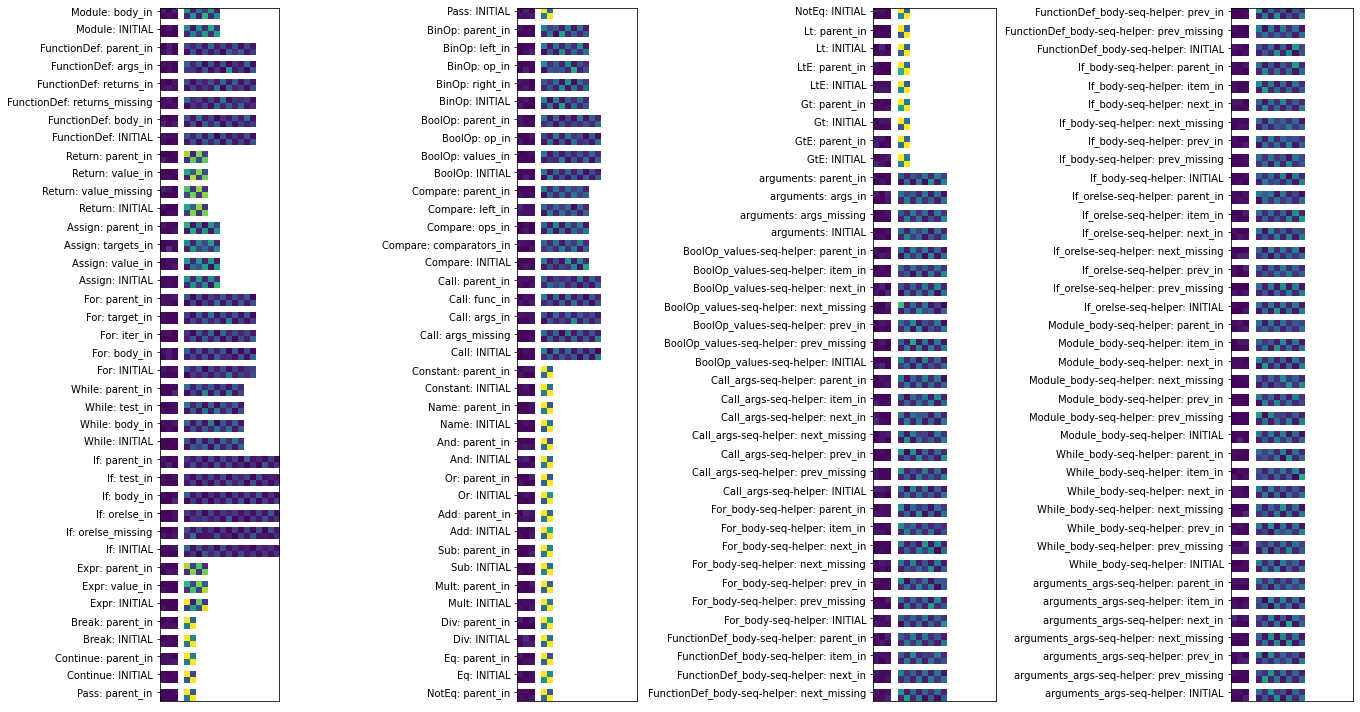

In [ ]:
initial_log_routing_params = initial_params["FiniteStateGraphAutomaton_0"]["log_routing_params_shared"]
visualization.ndarrays.show_routing_params(
    builder,
    builder.routing_softmax(initial_log_routing_params),
    rparams_are_logits=False,
    row_split_ct=4,
    figsize=(20, 10),
    vmax=.5, # to enhance detail
    colorbar=False)

## Training the model

To show how the model can be trained, this section includes a simplified training loop that runs in Colab. (See the "Advanced usage" for a more efficient way to train a model for practical use.)

We can start by generating a dataset of programs:

In [ ]:
rng = np.random.RandomState(42)
examples = []
while len(examples) < 500:
  the_ast = tasks.make_ast(150, rng, python_numbers_control_flow.CFG_DISTRIBUTION)
  generic_ast = py_ast_graphs.py_ast_to_generic(the_ast)
  mdp_graph, id_conversion_map = generic_ast_graphs.ast_to_graph(generic_ast, ast_spec=py_ast_graphs.PY_AST_SPECS)
  all_edges = (
      graph_edge_util.compute_jumps_out_edges(the_ast, id_conversion_map)
      + graph_edge_util.compute_same_identifier_edges(the_ast, id_conversion_map)
  )
  encoded_edges = graph_edge_util.encode_edges(all_edges, EDGE_TYPES)
  converted_example = graph_bundle.convert_graph_with_edges(mdp_graph, encoded_edges, builder)
  try:
    padded_example = graph_bundle.pad_example(
      converted_example,
      config=padding_config)
    examples.append((the_ast, padded_example))
  except ValueError:
    pass
  if len(examples) % 100 == 0:
    print(len(examples))
    sys.stdout.flush()

100
200
300
400
500


Now we set up our loss function and data iterator:

In [ ]:
def loss_fn(model, example, unused_metadata):
  """Compute cross-entropy loss between model output logits and target edges."""
  del unused_metadata
  unused_rng = jax.random.PRNGKey(0)  # For compatibility with stochastic baselines
  loss, metrics_dict = train_edge_supervision_lib.loss_fn(
      *train_edge_supervision_lib.extract_outputs_and_targets(
          model=model,
          padded_example_and_rng=(example, unused_rng),
          target_edge_index=EDGE_TYPES.index("EXTRA_JUMPS_OUT_OF"),
          num_edge_types=len(EDGE_TYPES)))
  return  loss, metrics_dict

In [ ]:
def data_iterator():
  rng = np.random.RandomState(1234)
  for epoch in itertools.count():
    shuffled_examples = list(enumerate(examples))
    rng.shuffle(shuffled_examples)
    for example_id, (_, padded_example) in shuffled_examples:
      yield train_util.ExampleWithMetadata(
          example=padded_example, epoch=epoch, example_id=example_id)

def batch_iterator():
  it = data_iterator()
  ldc = jax.local_device_count()
  it = data_loading.batch(it, (ldc, 32 // ldc))
  return it

In [ ]:
pprint(summarize_tree(next(batch_iterator())))

ExampleWithMetadata(
    epoch='int64(8, 4) [0, 0] nz:0.0',
    example_id='int64(8, 4) [7, 479] nz:1.0',
    example=GraphBundle(
                automaton_graph=EncodedGraph(
                                    initial_to_in_tagged=SparseCoordOperator(
                                                             input_indices='int32(8, 4, 1024, 1) [0, 552] nz:0.51',
                                                             output_indices='int32(8, 4, 1024, 2) [0, 497] nz:0.5',
                                                             values='float32(8, 4, 1024) 0.49 ±0.49 [0.0, 1.0] nz:0.51'),
                                    initial_to_special='int32(8, 4, 256) [0, 153] nz:0.75',
                                    in_tagged_to_in_tagged=SparseCoordOperator(
                                                               input_indices='int32(8, 4, 2048, 1) [0, 548] nz:0.81',
                                                               output_indices='int32(8, 4, 2048, 2) [

Now we can construct an optimizer:

In [ ]:
initial_optimizer = flax.optim.Adam().create(flax.deprecated.nn.Model(simple_model, initial_params))

And do a bit of training:

In [ ]:
run_name = datetime.datetime.now().strftime('%y_%m_%d__%H_%M_%S')

In [ ]:
# Takes about 10 to 15 minutes on a TPU.
# If you prefer, you can skip this step and load precomputed weights in the next cell.
trained_optimizer = simple_runner.training_loop(
    optimizer=initial_optimizer,
    train_iterator=batch_iterator(),
    loss_fn=loss_fn,
    validation_fn=None,
    max_iterations=3_000,
    learning_rate_schedule=learning_rate_schedules.ConstantLearningRateSchedule(0.01),
    artifacts_dir=f"/tmp/artifacts_{run_name}",
    steps_per_save=200,
)

INFO:absl:Setting up training loop.
INFO:absl:Peeking at dataset format...
INFO:absl:Starting main training loop.
INFO:absl:200: loss: 19.377723693847656 avg_per_non_target: 0.00021761865355074406 avg_per_target: 2.2486281394958496 batch_clf_thresh_at_0.1/f1: 0.40355727076530457 batch_clf_thresh_at_0.1/precision: 0.29276591539382935 batch_clf_thresh_at_0.1/recall: 0.6156994104385376 effective_p_model_given_nontarget: 0.00021898560225963593 effective_p_model_given_target: 0.11125928163528442 elapsed_hours: 0.009833792514271206 epoch: 12 gradient_global_norm: 1.7030329704284668 learning_rate: 0.01 positive_per_negative: 0.0001304901234107092 step: 200 worst: 2.693657875061035
INFO:absl:Saving a checkpoint at 200
INFO:absl:400: loss: 5.795314788818359 avg_per_non_target: 7.953135354910046e-05 avg_per_target: 0.5528256893157959 batch_clf_thresh_at_0.1/f1: 0.7735148668289185 batch_clf_thresh_at_0.1/precision: 0.65949946641922 batch_clf_thresh_at_0.1/recall: 1.0 effective_p_model_given_nonta

In [ ]:
# Set this to:
# - "last" to load final trained weights
# - "precomputed" to load precomputed weights (if you skipped the previous cell)
# - a multiple of 200 to load a checkpoint from partway through training.
load_what = "last"

if load_what == "last":
  trained_model = flax.jax_utils.unreplicate(trained_optimizer).target
elif load_what == "precomputed":
  checkpoint_optimizer, _ = simple_runner.load_from_checkpoint(initial_optimizer, "./gfsa/notebooks/demo_checkpoint.msgpack")
  trained_model = checkpoint_optimizer.target
else:
  checkpoint_optimizer, _ = simple_runner.load_from_checkpoint(initial_optimizer, f"/tmp/artifacts_{run_name}/checkpoints/current_at_{load_what}.msgpack")
  trained_model = checkpoint_optimizer.target

## Investigating the resulting policy

We can visualize the model weights, and see that the model has learned a policy for solving this simplified static analysis task.

Note that the leftmost pixel is only turned on for a small subset of rows, in particular `FunctionDef: body_in`, `For: parent_in`/`body_in`, and `While: body_in`. This is because the leftmost pixel corresponds to the "add edge and stop" action, and the only possible destinations for edges in this task are function definitions, for loops, and while loops.

(If you enabled variants: Recall that the `EXTRA_SAME_IDENTIFIER` edge only connects identifiers, so the parameters in the second column are only used when the agent is at a `Name` node. As a consequence, only the rows for `Name` nodes have changed after training.)

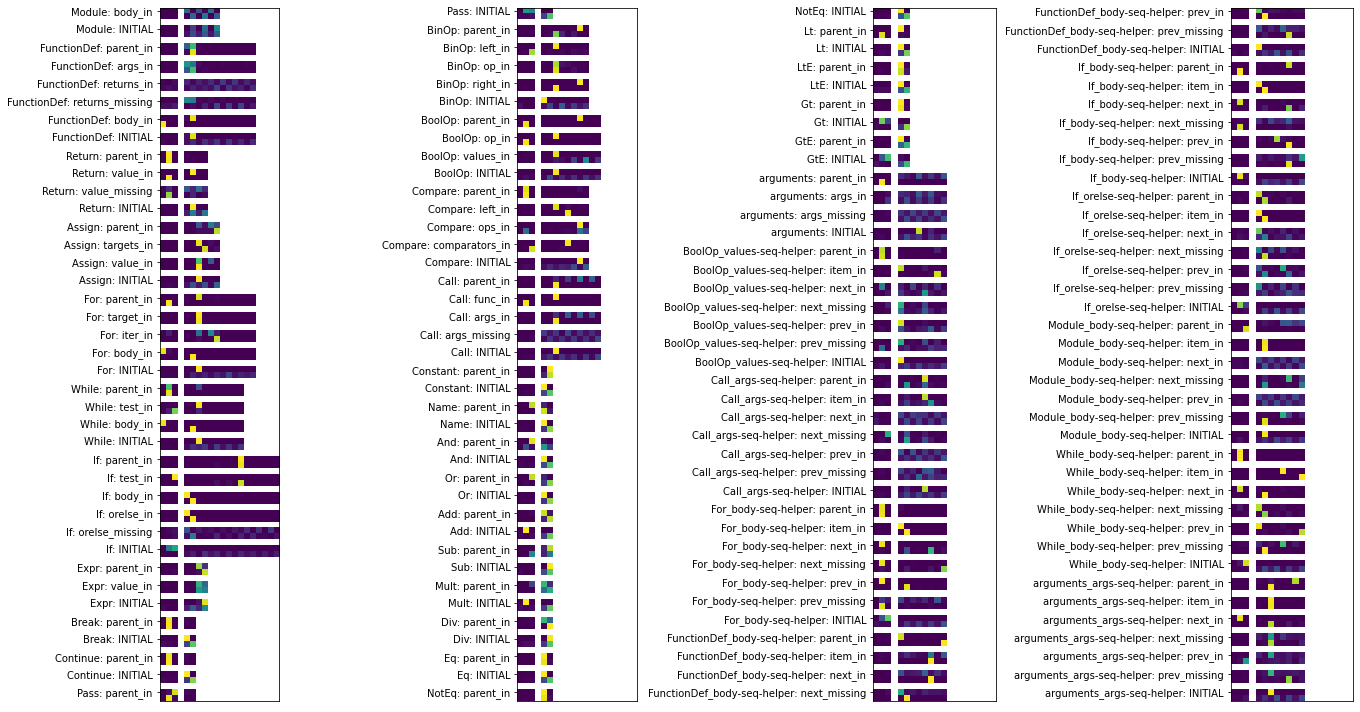

In [ ]:
trained_log_routing_params = trained_model.params["FiniteStateGraphAutomaton_0"]["log_routing_params_shared"]
visualization.ndarrays.show_routing_params(
    builder,
    builder.routing_softmax(trained_log_routing_params),
    rparams_are_logits=False,
    row_split_ct=4,
    figsize=(20, 10),
    colorbar=False)

Let's write our own custom Python function to see how it works:



In [ ]:
the_ast = gast.parse("""
def test_function(foo):
  for x in foo:
    if x:
      return True
    else:
      continue
  
  while False:
    while True:
      break
    continue
  
  return
""")

generic_ast = py_ast_graphs.py_ast_to_generic(the_ast)
mdp_graph, id_conversion_map = generic_ast_graphs.ast_to_graph(generic_ast, ast_spec=py_ast_graphs.PY_AST_SPECS)
all_edges = (
    graph_edge_util.compute_jumps_out_edges(the_ast, id_conversion_map)
    + graph_edge_util.compute_same_identifier_edges(the_ast, id_conversion_map)
)
encoded_edges = graph_edge_util.encode_edges(all_edges, EDGE_TYPES)
converted_example = graph_bundle.convert_graph_with_edges(mdp_graph, encoded_edges, builder)

test_example = graph_bundle.pad_example(
    converted_example,
    config=padding_config)

In [ ]:
def get_short_name(long_name):
  """Helper function to get a short name for an AST's MDP graph node."""
  path, nodetype = long_name.split("__")
  path_parts = path.split("_")
  levels = []
  for part in path_parts:
    if all(c in '0123456789' for c in part):
      levels[-1] = levels[-1] + "[" + part + "]"
    else:
      levels.append(part)
  last = levels[-1]
  num_rest = len(levels) - 1
  return "|"*num_rest + last + ": " + nodetype

In [ ]:
# Generate short summary names for each node, so we can visualize it easily
short_names = [f"{i:2d} " + get_short_name(k) for i, k in enumerate(mdp_graph.keys())]
maxlen = max(len(n) for n in short_names)
padded_names = [n + " " * (maxlen - len(n)) for n in short_names]

We can run the model on this example:

In [ ]:
model_output = jax.nn.sigmoid(trained_model(test_example))
target_output = edge_supervision_models.ground_truth_adjacency(
    example=test_example,
    graph_metadata=padding_config.static_max_metadata,
    target_edge_type="EXTRA_JUMPS_OUT_OF",
    all_edge_types=EDGE_TYPES)

Visualizing the model on our example, we can see that the model outputs match the ground-truth targets.

In this figure, the targets are on the left, and the model output is on the right. The Y axis indicates the location of the source node, and the X axis corresponds to the location of the target node.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f79057c3208>,
 <matplotlib.image.AxesImage at 0x7f7905771e80>)

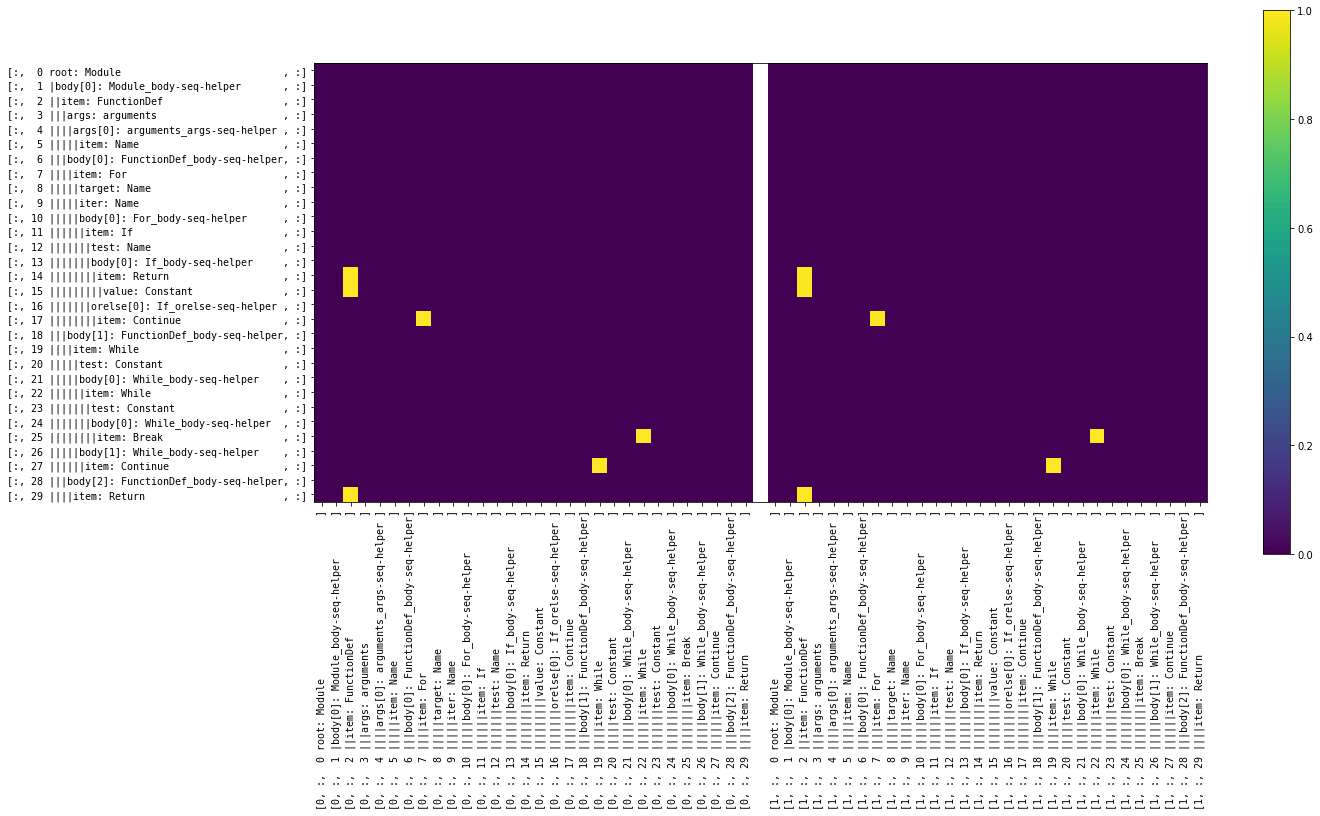

In [ ]:
num_nodes = test_example.graph_metadata.num_nodes
visualization.ndarrays.ndshow(
    jnp.stack([target_output, model_output])[:, :num_nodes, :num_nodes],
    "crc",
    figsize=(20,10),
    names={1:padded_names, 2:padded_names},
    ticks=True)

We can compare this to the output of an untrained model:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f790562eb70>,
 <matplotlib.image.AxesImage at 0x7f7905625a20>)

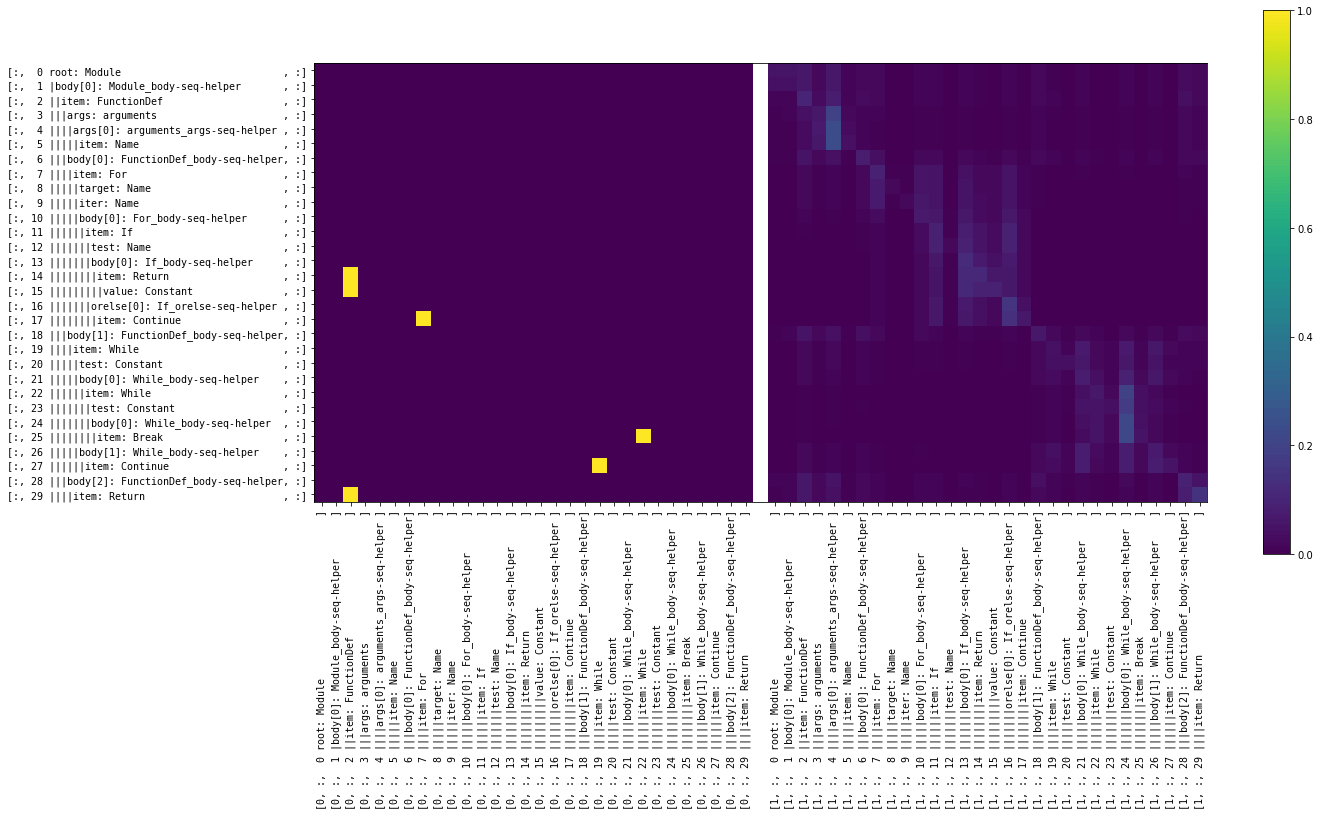

In [ ]:
untrained_output = jax.nn.sigmoid(initial_optimizer.target(test_example))
visualization.ndarrays.ndshow(
    jnp.stack([target_output, untrained_output])[:, :num_nodes, :num_nodes],
    "crc",
    figsize=(20,10),
    names={1:padded_names, 2:padded_names},
    ticks=True)

To get a better sense of *how* the learned policy works, we can simulate each step of the automaton individually, and visualize a heatmap of the location of the automaton at each timestep.

In [ ]:
def unroll_automaton(routing_param_logits: automaton_builder.RoutingParams, example: graph_bundle.GraphBundle, initial_node_index:int, rollout_steps: int):
  # Variants are the same as in model definition
  variant_weights = edge_supervision_models.variants_from_edges(
      example,
      graph_metadata=padding_config.static_max_metadata,
      variant_edge_type_indices=[EDGE_TYPES.index("EXTRA_SAME_IDENTIFIER")],
      num_edge_types=len(EDGE_TYPES))

  # Build the transition matrix for the combination of MDP and policy
  transition_matrix = builder.build_transition_matrix(
        builder.routing_softmax(routing_param_logits),
        example.automaton_graph,
        padding_config.static_max_metadata)

  initial_state = 0

  # Unroll
  unrolled = automaton_builder.unroll_chain_steps(
      builder=builder,
      transition_matrix=transition_matrix,
      variant_weights=variant_weights[initial_node_index],
      start_machine_state=(jnp.arange(2) == initial_state),
      node_index=initial_node_index,
      steps=rollout_steps)

  # Reformat for easier analysis
  aggregated = automaton_builder.aggregate_unrolled_per_node(
      unrolled,
      node_index=initial_node_index,
      initial_state=initial_state,
      transition_matrix=transition_matrix,
      graph_metadata=padding_config.static_max_metadata)

  return aggregated

In [ ]:
state_colors_dict = {
  "State A":            mpl.colors.to_rgb("#4e79a7"),
  "State B":            mpl.colors.to_rgb("#edc948"),
  "✓ Add edge and stop":  mpl.colors.to_rgb("#59a14f"),
  "← Backtrack":          mpl.colors.to_rgb("#b07aa1"),
  "✗ Stop":               mpl.colors.to_rgb("#e15759"),
}
state_symbols = "AB✓←✗"
state_colors = list(state_colors_dict.values())
legend_items = [
  mpl.patches.Patch(color=c, label=l)
  for l,c in state_colors_dict.items()
]

def show_automaton_steps(steps, ax):
  steps = np.array(steps)
  ax.imshow(np.einsum("sni,ic->nsc", steps[:, :num_nodes, :], state_colors))
  ax.set_yticks(np.arange(num_nodes))
  ax.set_yticklabels(labels=padded_names, family="monospace")
  ax.set_xlabel("Step number")

  for step in range(steps.shape[0]):
    for node in range(num_nodes):
      for i, sym in enumerate(state_symbols):
        d = np.sum(steps[step, node]) + 1e-3
        v = steps[step, node, i] / d
        if v > 0.05 and d > 0.05:
          ax.text(step, node, sym, c="black", alpha=v, verticalalignment="center", horizontalalignment="center")

At initialization time, the untrained policy behaves like a random walk and does not do any particular action with high probability (leading to "blurry" output colors):

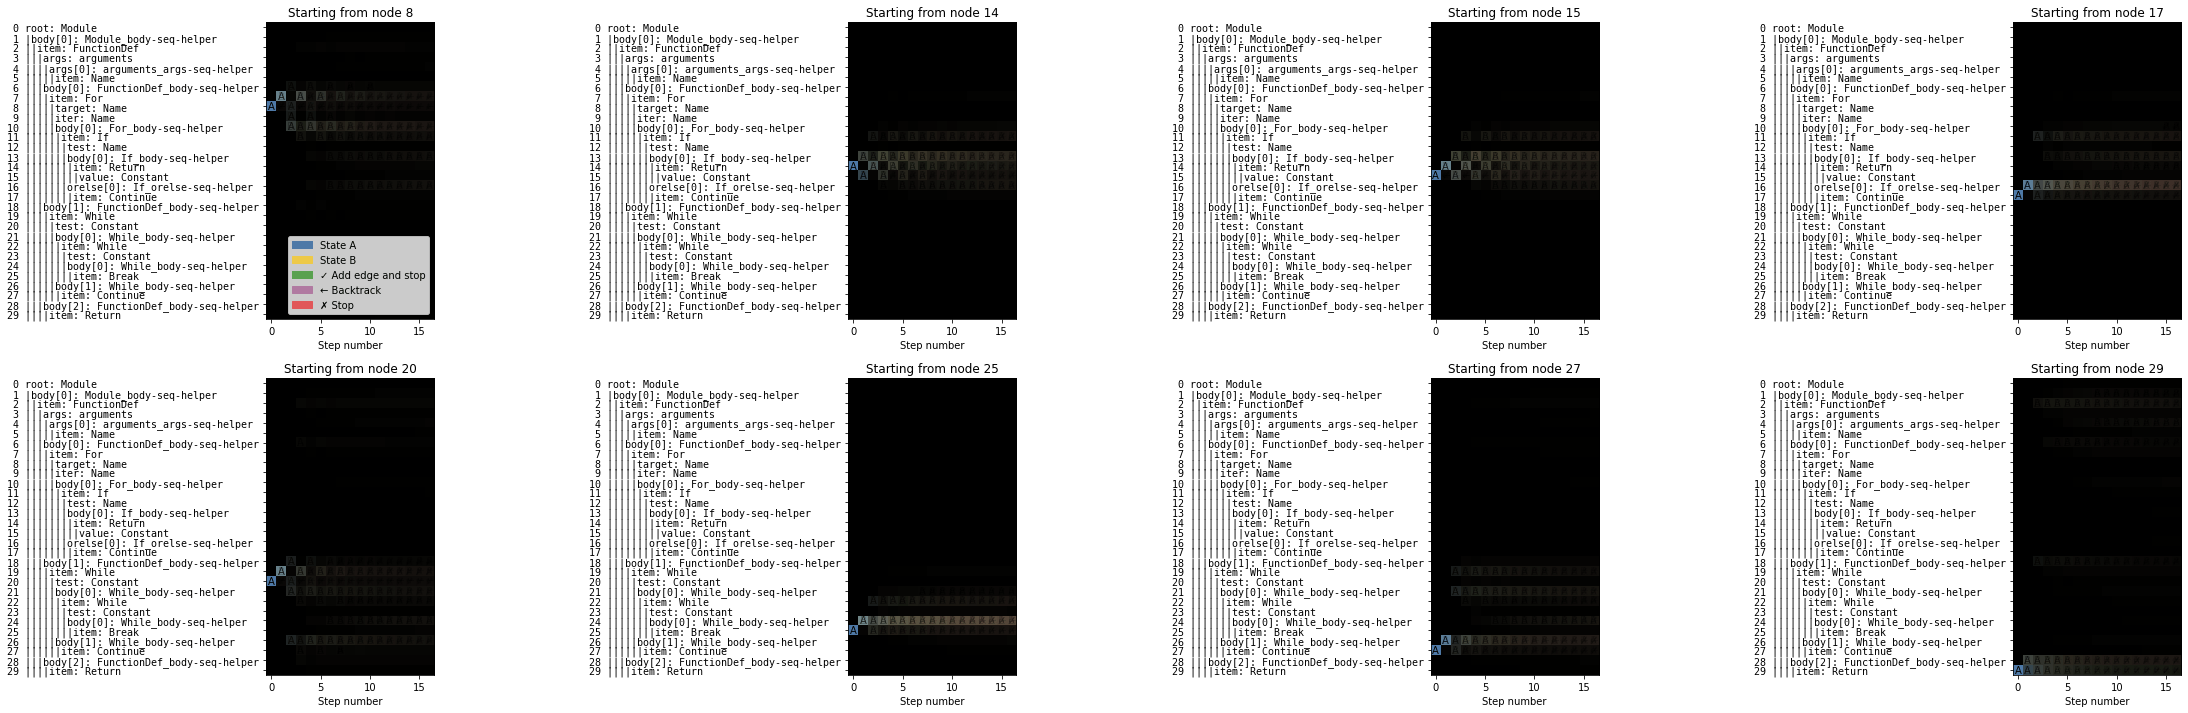

In [ ]:
starting_positions = [8, 14, 15, 17, 20, 25, 27, 29]
_, ax = plt.subplots(2, 4, figsize=(40, 12))
for i in range(8):
  r, c = np.unravel_index(i, (2, 4))
  starting_position = starting_positions[i]

  steps = unroll_automaton(initial_log_routing_params, test_example, initial_node_index=starting_position, rollout_steps=16)
  ax[r, c].set_title(f"Starting from node {starting_position}")
  show_automaton_steps(steps, ax[r, c])

  if i == 0:
    ax[r, c].legend(handles=legend_items, loc="lower right")

After training, the automaton policy has learned to take a single sequence of actions with high probability, solving the task:

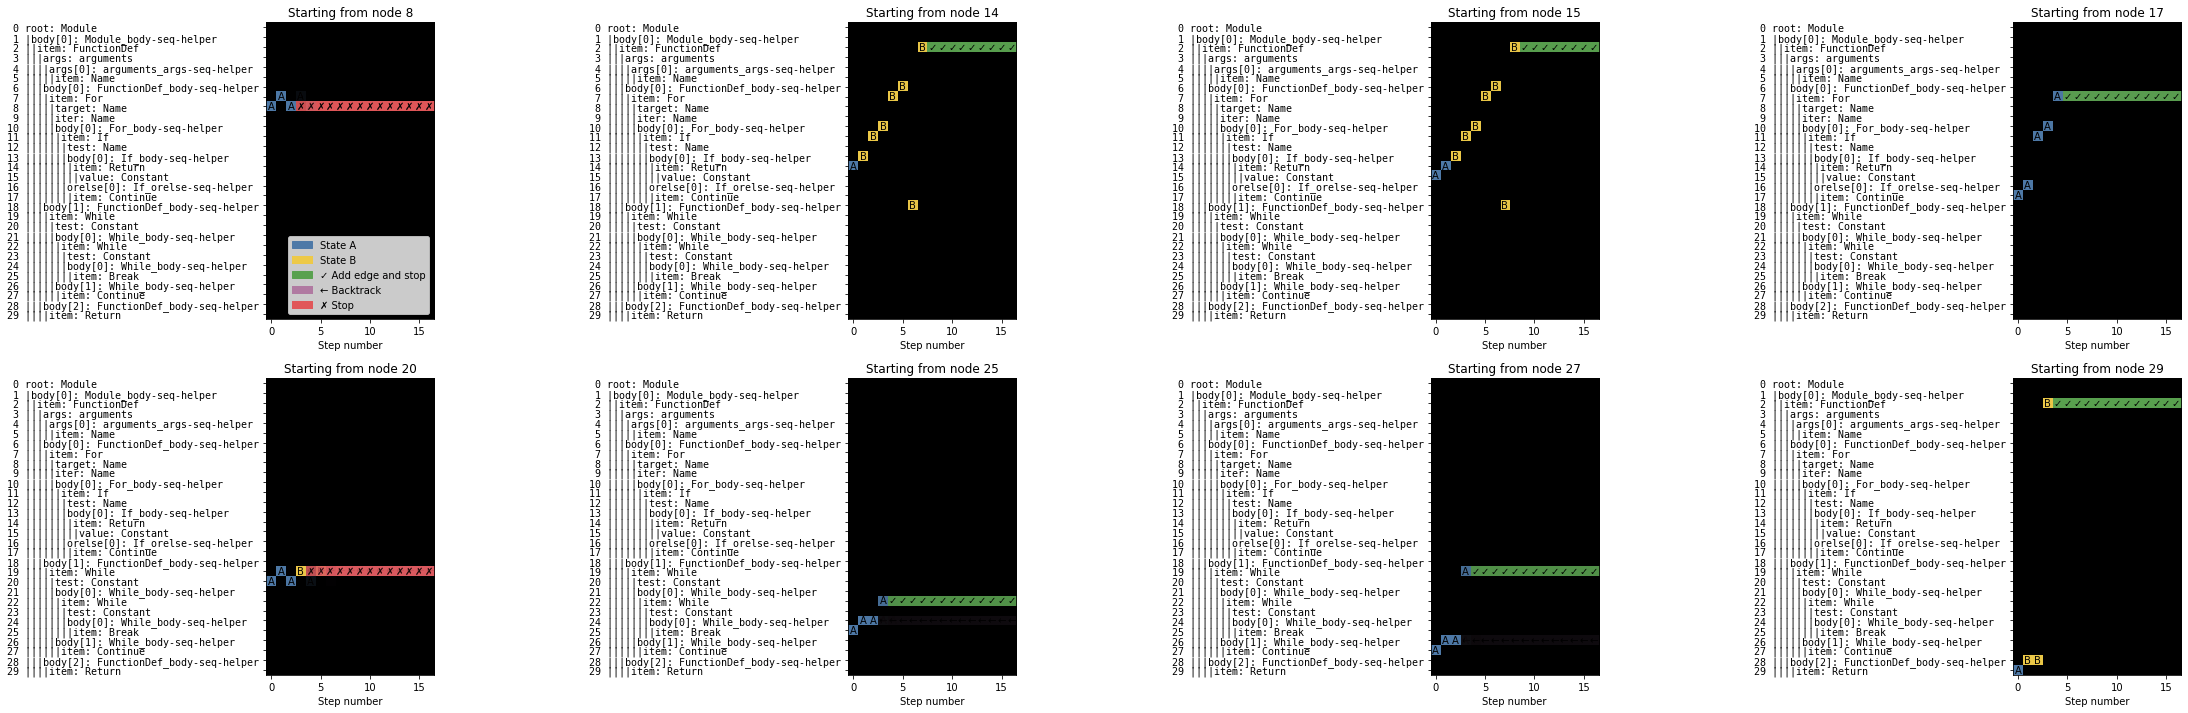

In [ ]:
starting_positions = [8, 14, 15, 17, 20, 25, 27, 29]

_, ax = plt.subplots(2, 4, figsize=(40, 12))
for i in range(8):
  r, c = np.unravel_index(i, (2, 4))
  starting_position = starting_positions[i]

  steps = unroll_automaton(trained_log_routing_params, test_example, initial_node_index=starting_position, rollout_steps=16)
  ax[r, c].set_title(f"Starting from node {starting_position}")
  show_automaton_steps(steps, ax[r, c])

  if i == 0:
    ax[r, c].legend(handles=legend_items, loc="lower right")

Some things to notice:

- When starting from node 8 or node 20 (not relevant to the task), the automaton moves to the parent node, sees that it is not a return statement, and halts without adding an edge.
- When starting from nodes 14, 15, or 29 (return statements or return values), the automaton switches to state B (yellow), walks up the tree until reaching the function definition, and adds an edge there.
- When starting from nodes 17, 25, or 27, it stays in state A (blue) and stops at the first while loop or for loop it finds.

(Note that different random seeds or hyperparameters may result in slightly different state-changing behaviors for this example.)

## Manually building the transition matrix and solving for the absorbing states

The sections above have taken care of running the automaton on the input graph automatically. However, if you want more control, you can run each of the steps individually.

In [ ]:
# Tiny AST to make visualization easier
the_ast = gast.parse("""
def test_function(foo):
  if foo:
    return
  pass
""")

generic_ast = py_ast_graphs.py_ast_to_generic(the_ast)
mdp_graph, id_conversion_map = generic_ast_graphs.ast_to_graph(generic_ast, ast_spec=py_ast_graphs.PY_AST_SPECS)

Instead of using `graph_bundle.convert_graph_with_edges`, which builds both the MDP environment and the extra edges at the same time, we can directly build the environment dynamics using the automaton builder object:

In [ ]:
encoded_mdp, mdp_metadata = builder.encode_graph(mdp_graph, as_jax=False)

pprint(summarize_tree(encoded_mdp))
mdp_metadata

EncodedGraph(
    initial_to_in_tagged=SparseCoordOperator(
                             input_indices='int32(47, 1) [3, 552] nz:1.0',
                             output_indices='int32(47, 2) [0, 35] nz:0.96',
                             values='float32(47,) 0.98 ±0.1 [0.5, 1.0]'),
    initial_to_special='int32(13,) [1, 153] nz:1.0',
    in_tagged_to_in_tagged=SparseCoordOperator(
                               input_indices='int32(158, 1) [0, 548] nz:0.99',
                               output_indices='int32(158, 2) [0, 35] nz:0.98',
                               values='float32(158,) 0.97 ±0.11 [0.5, 1.0]'),
    in_tagged_to_special='int32(36,) [0, 152] nz:0.97',
    in_tagged_node_indices='int32(36,) [0, 12] nz:0.97')


EncodedGraphMetadata(num_nodes=13, num_input_tagged_nodes=36)

Each of the fields in the `EncodedGraph` object describe different parts of the environment dynamics. However, they are stored in a sparse form that is difficult to visualize. In particular, they are encoded as sparse operators that transform a policy into a transition matrix, by indicating which policy actions result in which state changes (see the docstring for `EncodedGraph` in `automaton_builder.py` for more details).

This `EncodedGraph` could be fed into the high-level Flax wrapper. But it's also possible to run each of the steps directly in JAX. 
To obtain a transition matrix, we need to combine our encoded graph with some parameters. Let's use the ones from our trained model:

In [ ]:
learned_policy = builder.routing_softmax(trained_log_routing_params)

In [ ]:
transition_matrix = builder.build_transition_matrix(
    rparams=learned_policy,
    graph=encoded_mdp,
    metadata=mdp_metadata)

pprint(summarize_tree(transition_matrix))

AutomatonGraphTransitionMatrix(
    initial_to_in_tagged='float32(1, 13, 2, 36, 2) 0.012 ±0.087 [0.0, 1.0] nz:0.079',
    initial_to_special='float32(1, 13, 2, 3) 0.045 ±0.15 [7.6e-07, 0.97]',
    in_tagged_to_in_tagged='float32(1, 36, 2, 36, 2) 0.011 ±0.088 [0.0, 1.0] nz:0.099',
    in_tagged_to_special='float32(1, 36, 2, 3) 0.063 ±0.23 [1e-06, 0.99]',
    in_tagged_node_indices='int32(36,) [0, 12] nz:0.97')


The result is still broken up into blocks, which will be used to efficiently solve the linear system. First, we have the transitions from each possible `(initial_node, initial_state)` to each possible `(node, observation, hidden_state)` tuple (in other words, the transition matrix for the starting state). The columns here represent the different possible start nodes and start states, and the rows represent the possible `(node, observation, hidden_state)` tuples.


(<matplotlib.axes._subplots.AxesSubplot at 0x7f7905c99d30>,
 <matplotlib.image.AxesImage at 0x7f790396fd68>)

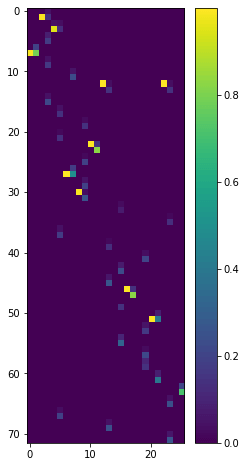

In [ ]:
visualization.ndarrays.ndshow(
    # Visualize only the first variant, which is used for almost all of the nodes
    transition_matrix.initial_to_in_tagged[0],
    "ccrr", figsize=(4, 8),
    colskips=lambda _: 0, rowskips=lambda _: 0)

Next, we have immediate transitions from the initial state to a halting state. Here, the columns represent the initial nodes, and each row corresponds to a special action (add edge and stop, backtrack, stop).

(<matplotlib.axes._subplots.AxesSubplot at 0x7f790394f9e8>,
 <matplotlib.image.AxesImage at 0x7f79038ba2b0>)

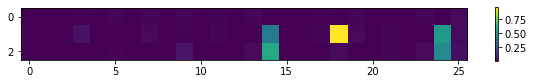

In [ ]:
visualization.ndarrays.ndshow(
    transition_matrix.initial_to_special[0],
    "ccr", figsize=(10, 1),
    colskips=lambda _: 0, rowskips=lambda _: 0)

Next we have the transitions from `(node, observation, hidden_state)` to `(node, observation, hidden_state)`, which make up the majority of the transitions in any given trajectory:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f790382aa20>,
 <matplotlib.image.AxesImage at 0x7f7903845e48>)

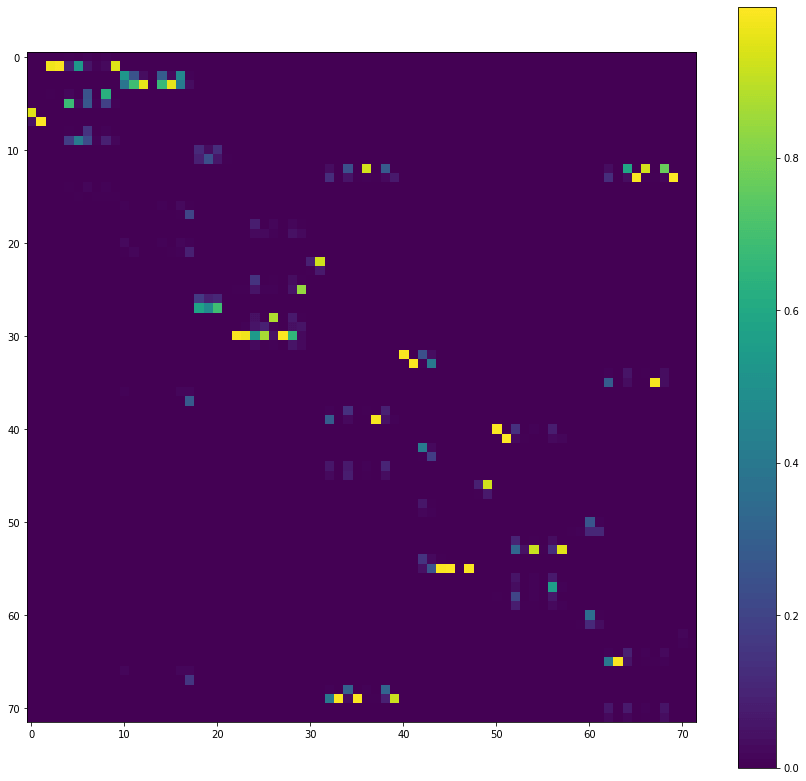

In [ ]:
visualization.ndarrays.ndshow(
    transition_matrix.in_tagged_to_in_tagged[0],
    "ccrr", figsize=(15, 14),
    colskips=lambda _: 0, rowskips=lambda _: 0)

Finally, we have transitions from intermediate states to halting states:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f79037ceba8>,
 <matplotlib.image.AxesImage at 0x7f7903775eb8>)

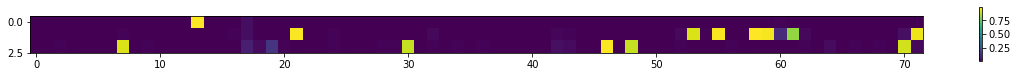

In [ ]:
visualization.ndarrays.ndshow(
    transition_matrix.in_tagged_to_special[0],
    "ccr", figsize=(20, 1),
    colskips=lambda _: 0, rowskips=lambda _: 0)

*(Try adding a for or while loop to the test function and seeing how the transition matrix changes!)*

We can solve for the absorbing distribution for this transition matrix using `all_nodes_absorbing_solve`, which does the heavy lifting of constructing and solving a batch of linear systems, and also sets up the implicit differentiation machinery so that gradients can be computed efficiently.

In [ ]:
num_nodes = mdp_metadata.num_nodes
absorbing_distribution = automaton_builder.all_nodes_absorbing_solve(
    builder=builder,
    transition_matrix=transition_matrix,
    variant_weights=jax.nn.one_hot(jnp.zeros([num_nodes, num_nodes]), 2 if USE_VARIANTS else 1),  # should sum to 1 across last axis if using multiple variants
    start_machine_states=jax.nn.one_hot(jnp.zeros([num_nodes]), 2),  # should sum to 1 across last axis if using multiple states
    steps=100,  # How long to run the solver for; determines the maximum trajectory length
)

pprint(summarize_tree(absorbing_distribution))

'float32(13, 13) 0.0059 ±0.076 [7.3e-16, 1.0]'


(<matplotlib.axes._subplots.AxesSubplot at 0x7f790380fa58>,
 <matplotlib.image.AxesImage at 0x7f79036d97b8>)

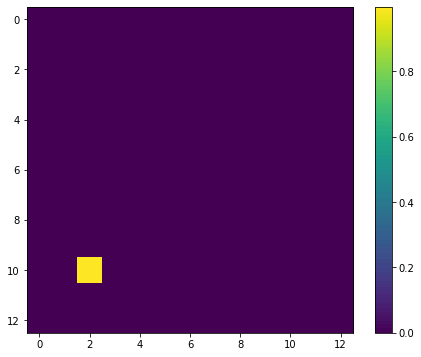

In [ ]:
visualization.ndarrays.ndshow(absorbing_distribution, figsize=(8, 6))

This matrix of absorbing probabilities is then optionally postprocessed with adjustment parameters, and then returned as the output of the GFSA layer. In this case, the layer adds one edge with high confidence.

This is a weighted adjacency matrix, so there are also weak connections between other nodes. We can visualize this by changing the colormap:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f790365d908>,
 <matplotlib.image.AxesImage at 0x7f79037ce7f0>)

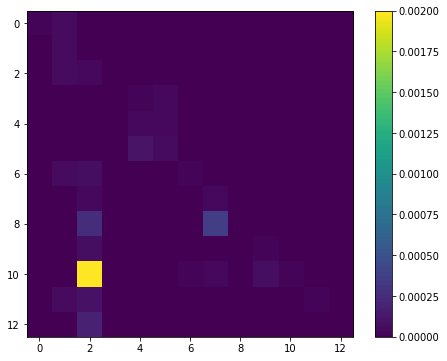

In [ ]:
visualization.ndarrays.ndshow(absorbing_distribution, figsize=(8, 6), vmax=0.002)

As the model trains, the loss function pushes these extra edge weights closer toward zero.

## Next steps

Thanks for following along through this interactive demo! If you'd like to try applying the GFSA layer for a different task, or want a more in-depth discussion of how to specify the schema for new MDPs, see the notebook ["Using the GFSA layer with new tasks"][new-tasks-colab].

[new-tasks-colab]: https://colab.research.google.com/github/google-research/google-research/blob/master/gfsa/notebooks/guide_for_new_tasks.ipynb